<a href="https://colab.research.google.com/github/avy666/LLM_Sber/blob/main/practice_lesson1_solved_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинный перевод

*Этот ноутбук базируется на [open-source имплементации](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb) seq2seq пайплайна, написанного на PyTorch и статье [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473).*

## План
1. Подготовка данных (токенизация, паддинг, формирование батчей)
2. Построение Seq2seq модели
  - Энкодер
  - Механизм внимания
  - Декодер
  - Seq2seq модель
3. Тренировка Seq2Seq модели
4. Inference модели
5. Заключение и выводы

## Введение

Обычный seq2seq пайплайн - это модель, содержащая encoder и decoder:

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq1.png)


Вектор контекста на последнем шаге энкодера содержит всю информацию о входном предложении, что порождает так называемую проблему "бутылочного горлышка". Модель, над которой мы будем работать сегодня решает эту проблему путем добавления механизма внимания: на каждом шаге декодирования мы разрешим декодеру обращаться к информации обо всем предложении, закодированной в скрытых состояниях энкодера.

Как работает механизм внимания? Для начала считаем вектор внимания, $a$. Это вектор вероятностей: каждый его элемент больше нуля и меньше единицы, весь вектор суммируется в единицу. Дальше считаем взвешенную сумму скрытых состояний энкодера, $H$, чтобы получить вектор, $w$.

$$w = \sum_{i}a_ih_i$$

Такой вектор мы считаем заново на каждом шаге декодирования, подавая его на вход декодеру вместе со скрытым состоянием с прошлого шага декодирования.

## Подготовка данных

Импортируем все необходимые библиотеки. Далее загружаем датасет Multi30k из torchtext.datasets и используем WordPunctTokenizer из библиотеки NLTK для его токенизации.

In [ ]:
!pip install portalocker>=2.0.0

In [ ]:
!pip install torch==2.0.1
!pip install torchtext==0.15.2
!pip install torchdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torchtext.datasets import multi30k, Multi30k

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt16_task1_test.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset
multi30k.MD5["test"] = "6d1ca1dba99e2c5dd54cae1226ff11c2551e6ce63527ebb072a1f70f72a5cd36"

train_data = list(Multi30k(split='train'))
val_data = list(Multi30k(split='valid'))

In [ ]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
src, trg = train_data[0]

In [ ]:
def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())


print(tokenize(src))
print(tokenize(trg))

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [ ]:
from collections import Counter

from torchtext.vocab import vocab as Vocab

src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)
trg_vocab = Vocab(trg_counter, min_freq=2)

In [ ]:
len(src_vocab), len(trg_vocab)

(7888, 5899)

In [ ]:
unk_token = "<unk>"

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

In [ ]:
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]
for vocab in [src_vocab, trg_vocab]:
    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (de) vocabulary: 7892
Unique tokens in target (en) vocabulary: 5903


In [ ]:
# Токенизируем предложение и добавляем специальные токены <sos> и <eos>.
tokenized = [sos_token] + tokenize(trg) + [eos_token]

# Трансформируем токены в индексы используя словарь.
encoded = [trg_vocab[tok] for tok in tokenized]

[(tok, idx) for tok, idx in zip(tokenized, encoded)]

[('<sos>', 5900), ('<eos>', 5901)]

In [ ]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]


# После выполнения [::-1] токен <eos> оказывается в начале предложения,
# в то время как токен <sos> оказывается в конце.
# Повлияет ли это на обучение модели?
print(encode(src, src_vocab)[::-1])
print(encode(trg, trg_vocab))

[7890, 7889]
[5900, 5901]


In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        # YOUR CODE HERE
        # Кодируем src и trg предложения, конвертируем их в тензор
        # и храним их в переменных src_list и trg_list.
        src_encoded = encode(src, src_vocab)[::-1]
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    # Паддинг (добавляем pad_token в конец предложения столько раз, чтобы все
    # предложения в батче были одной длины).
    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded


batch_size = 256
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([26, 256]), torch.Size([28, 256]))

In [ ]:
val_data = list(Multi30k(split="valid"))
val_dataloader = DataLoader(val_data, batch_size, collate_fn=collate_batch)

## Построение Seq2Seq модели

### Энкодер

Будем использовать *bidirectional RNN* - теперь на каждом слое у нас по две RNN. *forward RNN* идет по предложению слева направо (на картинке обозначено зеленым), в то время как *backward RNN* идет справа налево. Для реализации такой логики в коде достаточно указать `bidirectional = True`.

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq8.png)


$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Здесь $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ и $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

Инициализируем и forward, и backward скрытые состояния ($h_0^\rightarrow$ и $h_0^\leftarrow$) нулями. Также обозначим
два вектора контекста переменными $z$: один из forward RNN после того, как он увидел последнее слово в предложении, $z^\rightarrow=h_T^\rightarrow$, и один из backward RNN, после того как он увидел первое слово в предложении $z^\leftarrow=h_T^\leftarrow$.

RNN возвращает переменные `outputs` и `hidden`.

Размер переменной `outputs` --- **[src len, batch size, hid dim * num directions]** где первые `hid_dim` элементы по третьей размерности --- это скрытые состояния с верхнего слоя forward RNN, а последние `hid_dim` элементы --- это скрытые состояния с верхнего слоя backward RNN. Можно рассматривать третью размерность как скрытые состояния forward и backward RNN, сконкатенированные вместе, то есть $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$. Обозначим все скрытые состояния энкодера (сконкатенированные forward и backward) $H=\{ h_1, h_2, ..., h_T\}$.

Переменная `hidden` имеет размер **[n layers * num directions, batch size, hid dim]**, где **[-2, :, :]** выдает скрытое состояние верхнего слоя forward RNN после финального таймстепа (т.е. после того как он увидел последнее слово в предложении) и **[-1, :, :]** выдает скрытое состояние верхнего слоя backward RNN после того, как он увидел первое слово в предложении.

Декодер однонаправленный, ему нужен только один вектор контекста ($z$), но у нас их два ($z^\rightarrow=h_T^\rightarrow$ и $z^\leftarrow=h_T^\leftarrow$). Сконкатенируем два вектора контекста вместе, передадим их через линейный слой, $g$, и применим функцию активации $\tanh$.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

In [ ]:
from torch import nn


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        #src = [src len, batch size]

        embedded = self.embedding(src)
        embedded = self.dropout(embedded)

        #embedded = [src len, batch size, emb dim]


        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]

        #hidden - [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs всегда приходят с последнего слоя

        #hidden [-2, :, : ] --- последний слой forward RNN
        #hidden [-1, :, : ] --- последний слой backward RNN

        # первое скрытое состояние декодера - это последнее скрытое состояние
        # forward и backward RNN из энкодера, пропущенные через линейный слой

        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]

        return outputs, hidden

### Механизм внимания

Нам понадобится предыдущее скрытое состояние декодера, $s_{t-1}$, и все скрытые состояния энкодера (и forward, и backward), $H$. На выходе слоя будет вектор внимания, $a_t$, длиной как входное предложение.

Этот слой на вход принимает всю информацию, которую мы закодировали на текущий момент, $s_{t-1}$ и $H$, чтобы на выход отдать вектор $a_t$, который показывает, на какие слова во входном предложении мы должны обратить особое внимание, чтобы декодер мог правильно предсказать следующее слово, $\hat{y}_{t+1}$.

Сначала считаем *энергию* предыдущим скрытым состоянием декодера и всеми скрытыми состояниями энкодера.

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$

Можно интерпретировать эту переменную как подсчет насколько хорошо каждое скрытое состояние энкодера матчит предыдущее скрытое состояние декодера.

Для каждого предложения в батче у нас есть тензор размера **[dec hid dim, src len]**. Мы хотим, чтобы его размер был **[src len]** для каждого примера в батче, так как механизм внимания должен пройтись по всему входному предложению. Это достигается путем умножения `энергии` на тензор размера **[1, dec hid dim]**, $v$.

$$\hat{a}_t = v E_t$$

$v$ --- это по факту веса, с которыми будем считать взвешенную сумму энергий по всем скрытым состояним энкодера. Эти веса говорят нам, насколько много внимания надо уделить каждому токену во входной последовательности. Параметры вектора $v$ инициализируются рандомно, но учатся вместе с остальными весами сети методом обратного распространения ошибки. Заметим, что $v$ не зависит от времени, и тот же самый вектор $v$ используется на каждом шаге декодирования. Будем имплементировать $v$ как линейный слой без bias.

Наконец пропускаем вектор через софтмакс, чтобы на выходе получить вектор вероятностей:

$$a_t = \text{softmax}(\hat{a_t})$$

Получаем финальный вектор внимания по всему предложению!

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn_fc = nn.Linear(
            (enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim
        )
        self.v_fc = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):

        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # повторить скрытое состояние src_len раз
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))

        #energy = [batch size, src len, dec hid dim]

        attention = self.v_fc(energy).squeeze(2)

        #attention= [batch size, src len]

        return F.softmax(attention, dim=1)

### Декодер

Декодер содержит слой attention, который принимает на вход предыдущее скрытое состояние энкодера, $s_{t-1}$, и все скрытые состояния энкодера, $H$, и возвращает вектор внимания, $a_t$.

Далее используем этот вектор внимания, чтобы посчитать взвешенную сумму векторов, $w_t$ (переменная `weighted`), которая представляет из себя взвешенную сумму скрытых состояний энкодера, $H$, использующую $a_t$ в качестве весов.

$$w_t = a_t H$$

Эмбеддинг первого слова, $d(y_t)$, взвешенный входной вектор, $w_t$, и прошлое скрытое состояние декодера, $s_{t-1}$, пропускаем через декодирующую RNN, конкатенируя $d(y_t)$ и $w_t$ вместе.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

Далее пропускаем $d(y_t)$, $w_t$ и $s_t$ через линейный слой, $f$, чтобы получить предсказание следующего слова в выходном предложении, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq10.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):

        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]

        input = input.unsqueeze(dim=0)

        #input = [1, batch size]

        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs)

        #a = [batch size, src len]

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a, encoder_outputs)

        #weighted = [batch size, 1, enc hid dim * 2]

        weighted = weighted.permute(1, 0, 2)

        #weighted = [1, batch size, enc hid dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim=2)

        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers и n directions будут всегда 1 в этом декодере, поэтому:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        #prediction = [batch size, output dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq модель

В этой модели необязательно делать RNN в энкодере и декодере с одинаковым размером скрытого состояния.

`encoder` возвращает финальное скрытое состояние, которое является финальным скрытым состоянием forward и backward RNN, пропущенными через линейный слой, чтобы использовать его как стартовое скрытое состояние декодера. Также нужно удостовериться, что `hidden` и `encoder_outputs` переданы в декодер.

Коротко пройдемся по основным шагам:
- тензор `outputs` создан, чтобы хранить предсказания модели, $\hat{Y}$
- входное предложение, $X$, подается в энкодер, чтобы получить $z$ и $H$
- изначальное скрытое состояние декодера - это вектор `context`, $s_0 = z = h_T$
- мы используем батч, состоящий из токенов `<sos>` в качестве первого `input`, $y_1$
- дальше декодируем в цикле:
  - передаем входной токен $y_t$, скрытое состояние с предыдущего шага, $s_{t-1}$, и все выходы энкодера, $H$, в декодер
  - получаем предсказание, $\hat{y}_{t+1}$, и новое скрытое состояние, $s_t$
  - дальше решаем, будем использовать teacher force или нет.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio --- это вероятность использованияteacher forcing
        #т.е. если teacher_forcing_ratio = 0.75 мы используем teacher forcing в 75% случаях

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #тензор для хранения выходов декодера
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #encoder_outputs - это все скрытые состояния входного предложения
        #(как из backward RNN, так и из forward)
        #hidden - это финальные скрытые состояние forward и backward сетей,
        #пропущенные через линейный слой.
        encoder_outputs, hidden = self.encoder(src)

        #первый вход декодера - это <sos> токен
        input = trg[0,:]

        for t in range(1, trg_len):

            #передаем на вход эмбеддинг входного токена, скрытое состояние
            #с предыдущего шага и все скрытые состояния энкодера
            #получаем выходной тензор (предсказания) и новое скрытое состояние
            output, hidden, a = self.decoder(input, hidden, encoder_outputs)

            #добавляем предсказания в тензор предсказаний для каждого токена
            outputs[t] = output

            #решаем, будем ли использовать teacher forcing на этом шаге
            teacher_force = random.random() < teacher_forcing_ratio

            #берем токен с максимальной вероятностью
            top1 = output.argmax(1)

            #если включен teacher forcing, используем настоящий следующий токен
            #если нет, предсказанный
            input = trg[t] if teacher_force else top1

        return outputs

## Тренировка Seq2Seq модели

Инициализиуем энкодер, декодер и seq2seq модель.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
OUTPUT_DIM

5903

Инициализиуем все biases нулем, а все веса нормальным распределением $\mathcal{N}(0, 0.01)$.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7892, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5903, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5903, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Считаем количество параметров сети.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,548,879 trainable parameters


Инициализируем оптимизатор.

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters())

Инициализируем функцию потерь.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

In [ ]:
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm, trange

import torch.nn.functional as F
import random



writer = SummaryWriter()
n_epochs = 15
clip = 1
global_step = 0
for epoch in trange(n_epochs, desc="Epochs"):
    model.train()
    train_loss = 0
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False):
        # Используем модель для получения предсказания и подсчета лосса.
        # Дальше делаем: zero gradients, прогон метода обратного распространения
        # ошибки, обрезку градиентов и обновление весов модели.
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()


        train_loss += loss.item()
        writer.add_scalar("Training/loss", loss.item(), global_step)
        global_step += 1


    train_loss /= len(train_dataloader)
    writer.add_scalar("Evaluation/train_loss", train_loss, epoch)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False):
            # Еще раз считаем предсказание модели и лосс,
            # но теперь не обновляем веса модели.
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) # выключаем teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    writer.add_scalar("Evaluation/val_loss", val_loss, epoch)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Val:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "gru_attention_model.pt")

In [ ]:
model.load_state_dict(torch.load("gru_attention_model.pt"))

<All keys matched successfully>

### **Inference** модели

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for src, trg in val_data[:4]:
        attention_map = []
        encoded = encode(src, src_vocab)[::-1]
        encoded = torch.tensor(encoded)[:, None].to(device)
        encoder_outputs, hidden = model.encoder(encoded)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden, a = model.decoder(decoder_input, hidden, encoder_outputs)
            attention_map.append(a.cpu())
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                break

            pred_tokens.append(pred_token.item())
        attention_map = torch.cat(attention_map).squeeze(axis=1).numpy()[:, ::-1]
        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

src: 'eine gruppe von männern lädt baumwolle auf einen lastwagen'
trg: 'a group of men are loading cotton onto a truck'
pred: 'a group of men are putting on a structure .'

src: 'ein mann schläft in einem grünen raum auf einem sofa.'
trg: 'a man sleeping in a green room on a couch.'
pred: 'a man sleeping sleeping on a couch in a green room .'

src: 'ein junge mit kopfhörern sitzt auf den schultern einer frau.'
trg: 'a boy wearing headphones sits on a woman's shoulders.'
pred: 'a boy wearing a sits on sits on a woman ' s shoulders .'

src: 'zwei männer bauen eine blaue eisfischerhütte auf einem zugefrorenen see auf'
trg: 'two men setting up a blue ice fishing hut on an iced over lake'
pred: 'two men are a blue <unk> ride on a lake .'



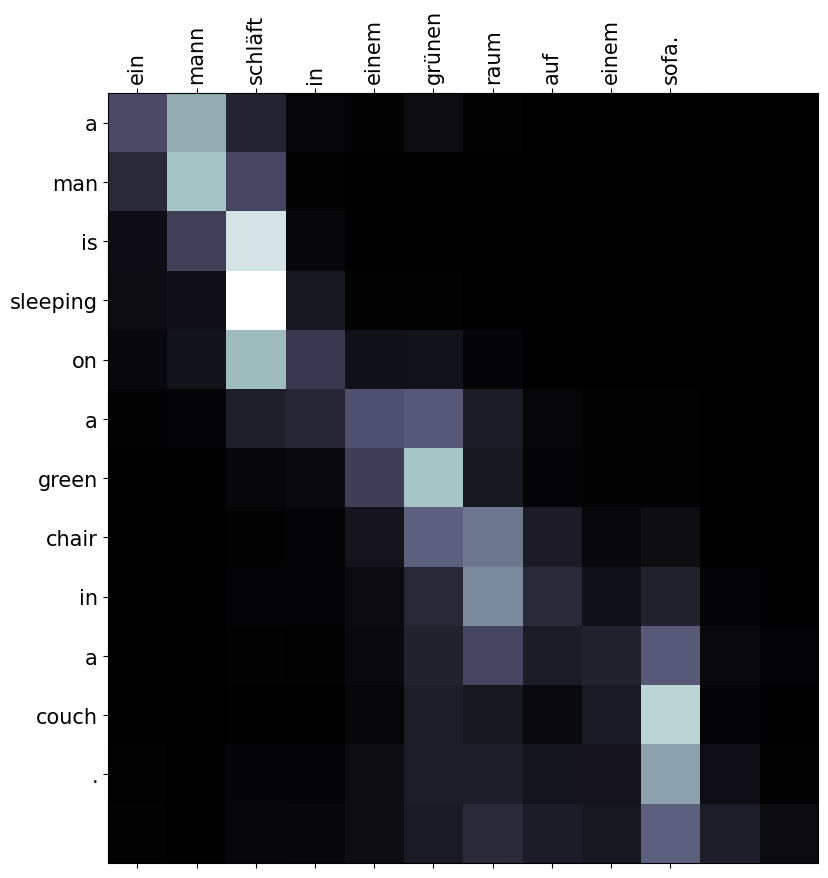

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention[:, 1:]
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

sentence = val_data[0][0]
expected_translation = val_data[0][1]
plot_attention(src.rstrip().lower().split(' '), [trg_itos[i] for i in pred_tokens], attention_map)

Получившиеся переводы выглядят логично и связно, но в них все еще встречается большое количество ошибок и несоответствий. Простой модели с использованием двух RNN явно недостаточно, чтобы получить стабильный результат перевода.

## Заключение и выводы
На этом уроке мы имплементировали простой пайплайн машинного перевода. Полученная seq2seq модель состоит из энкодера и декодера (две RNN) с механизмом внимания. Сеть тренируется в end-to-end стиле на корпусе параллельных текстов Multi30k. Важно отметить, что механизм внимания помогает не только улучшить качество перевода, но и позволяет без дополнительных усилий получить карты выравнивания слов на разных языках друг относительно друга (если визуализировать веса механизма внимания, получим карту, показывающую как токены из двух словарей соотносятся друг с другом). Тем не менее, данная модель не позволяет получить высокое качество перевода, периодически встречаются повторения токенов, часть смысла исходного предложения теряется, есть грамматические ошибки. Также модели сложно работать с контекстом большой длины.